In [2]:
import ee
import google.oauth2.credentials
import pywt
import folium

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='wavelet-project')




Successfully saved authorization token.


In [11]:

def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

# Define the geographical area and filtering criteria
point = ee.Geometry.Point([-99.9018, 41.4925])
region = point.buffer(10000).bounds()
l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA')\
        .filterDate('2022-01-01', '2023-12-31')\
        .filterBounds(region)\
        .filter(ee.Filter.lt('CLOUD_COVER', 20))

if l8.size().getInfo() > 0:
    image = l8.first()
    clipped_image = image.clip(region)
    vis_params = {
        'bands': ['B4', 'B3', 'B2'],
        'min': 0,
        'max': 0.5,  # Adjusted for typical scaled TOA reflectance values
        'gamma': 1
    }

    map = folium.Map(location=[41.4925, -99.9018], zoom_start=10)
    map.add_ee_layer(clipped_image, vis_params, "Landsat 8 TOA Image")
    map.add_child(folium.LayerControl())
    display(map) # Explicitly display the map in the notebook
else:
    print("No images found for the specified filters and date range.")

In [4]:
import geopandas as gpd
import ee
ee.Initialize()

# Read the shapefile using Geopandas
gdf = gpd.read_file('training_data_change.shp')

# Function to convert a GeoDataFrame to a FeatureCollection
def geodataframe_to_ee(gdf, ge_column='geometry'):
    features = []
    for _, row in gdf.iterrows():
        geometry = ee.Geometry(row[ge_column].__geo_interface__)
        properties = row.drop(ge_column).to_dict()
        feature = ee.Feature(geometry, properties)
        features.append(feature)
    return ee.FeatureCollection(features)

# Convert the GeoDataFrame to a FeatureCollection
training_shp = geodataframe_to_ee(gdf)

# Continue with your operations here...


In [12]:
import ee
import geemap


# Define the region of interest.
ROI = ee.Geometry.Polygon(
    [[[-84.22321259455788, 33.465997140167154],
          [-84.22321259455788, 33.35279362192921],
          [-84.08253609614479, 33.35279362192921],
          [-84.08253609614479, 33.465997140167154]]])

# Set up date ranges.
before_date_range = ["1989-5-1", "2002-10-01"]
after_date_range = ["2022-5-1", "2023-10-01"]

# Load Landsat imagery.
ls8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
ls5 = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")

# Function to filter and preprocess images.
def filter_and_scale(img, valid_qa):
    qa_mask = img.select('QA_PIXEL').remap(valid_qa, ee.List.repeat(1, len(valid_qa)), 0)
    img = img.updateMask(qa_mask)
    return img.select('SR_B.*').multiply(0.0000275).add(-0.2)

# Apply functions to image collections.
ls8_processed = ls8.filterDate(*after_date_range).filterBounds(ROI).map(lambda img: filter_and_scale(img, [21824, 21952])).map(lambda img: img.addBands(img.normalizedDifference(['SR_B5', 'SR_B4']).rename('ndvi')))
ls5_processed = ls5.filterDate(*before_date_range).filterBounds(ROI).map(lambda img: filter_and_scale(img, [5440, 5568])).map(lambda img: img.addBands(img.normalizedDifference(['SR_B4', 'SR_B3']).rename('ndvi')))

# Create composite images.
after_img = ls8_processed.qualityMosaic('ndvi').select(['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ndvi']).rename(['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2', 'NDVI']).clip(ROI)
before_img = ls5_processed.qualityMosaic('ndvi').select(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7', 'ndvi']).rename(['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2', 'NDVI']).clip(ROI)

# Stack images for classification.
multidate_img = ee.Image.cat([before_img, after_img]).rename(['BLUE_b', 'GREEN_b', 'RED_b', 'NIR_b', 'SWIR1_b', 'SWIR2_b', 'NDVI_b', 'BLUE_a', 'GREEN_a', 'RED_a', 'NIR_a', 'SWIR1_a', 'SWIR2_a', 'NDVI_a'])

# # Load training data.
# training_shp = geodataframe_to_ee(gdf)
# training_pts = multidate_img.sampleRegions(
#     collection=training_shp,
#     properties=['class'],
#     scale=30,
#     tileScale=4
# )

# # Random Forest classification.
# classifier = ee.Classifier.smileRandomForest(200).train(features=training_pts, classProperty='class', inputProperties=multidate_img.bandNames())
# classified = multidate_img.select(multidate_img.bandNames()).classify(classifier).clip(ROI)

# Convert the images to TileLayer
after_img_tile = after_img.getMapId({'bands': ['RED', 'GREEN', 'BLUE'], 'min': 0, 'max': 0.15})
before_img_tile = before_img.getMapId({'bands': ['RED', 'GREEN', 'BLUE'], 'min': 0, 'max': 0.15})

# Create a Folium map centered on the ROI
m = folium.Map(location=[ROI.centroid().getInfo()['coordinates'][1], ROI.centroid().getInfo()['coordinates'][0]], zoom_start=8)

# Add the images to the map
folium.TileLayer(
    tiles=after_img_tile['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='After Image',
).add_to(m)

folium.TileLayer(
    tiles=before_img_tile['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='Before Image',
).add_to(m)

# Add a layer control panel to the map
m.add_child(folium.LayerControl())

# Display the map
m


In [13]:

# Assuming after_img and ROI are defined
task = ee.batch.Export.image.toDrive(**{
    'image': multidate_img.toFloat(),
    'description': 'after_image_export',
    'folder': 'EarthEngineImages',
    'fileNamePrefix': 'multidate_image',
    'scale': 30,
    'region': ROI.coordinates().getInfo(),
    'fileFormat': 'GeoTIFF',
    'formatOptions': {
        'cloudOptimized': True
    }
})
task.start()



In [158]:
import rasterio

# Open the image file
with rasterio.open('multidate_image.tif') as src:
    image = src.read()  # This reads all bands; use src.read(1) to read a specific band
    transform = src.transform

print("Image shape:", image.shape)  # Should be (bands, height, width)



Image shape: (14, 421, 523)


In [147]:
# White roof detection code

import pywt
import numpy as np
from skimage.transform import resize

from numpy import pad

def apply_wavelet_extract_details(image, wavelet='haar', level=1):
    coeffs = pywt.wavedecn(image, wavelet, level=level)
    # Get the shapes of all detail coefficients
    detail_sizes = [coeff_dict[key].shape for coeff_dict in coeffs[1:] for key in coeff_dict]
    max_size = max(detail_sizes, key=lambda x: (x[0], x[1]))

    # Prepare to combine details in a more selective and normalized way
    combined_details = np.zeros(max_size)

    # Process coefficients more selectively, focusing on significant details
    for coeff_dict in coeffs[1:]:
        for key in coeff_dict:
            detail = np.abs(coeff_dict[key])
            # Normalize each detail array before resizing and summing
            norm_detail = detail / np.max(detail) if np.max(detail) != 0 else detail
            resized_detail = resize(norm_detail, max_size, mode='reflect', anti_aliasing=True)
            combined_details += resized_detail

    # Normalize the combined details to prevent any one band from dominating
    combined_details = combined_details / np.max(combined_details) if np.max(combined_details) != 0 else combined_details
    return combined_details


# Example usage, assuming 'image' is a 2D numpy array of one band
transformed_bands = [apply_wavelet_extract_details(band, wavelet='haar', level=5) for band in image]

# Stack the transformed bands back into a 3D numpy array if you have multiple bands
transformed_image = np.stack(transformed_bands)




In [159]:
import numpy as np
import pywt
from skimage.transform import resize

def apply_wavelet_transform(image, wavelet='db4', level=2):
    coeffs = pywt.wavedecn(image, wavelet, level=level)
    detail_sizes = [coeff_dict[key].shape for coeff_dict in coeffs[1:] for key in coeff_dict]
    max_size = max(detail_sizes, key=lambda x: (x[0], x[1]))

    combined_details = np.zeros(max_size)
    for coeff_dict in coeffs[1:]:
        for key in coeff_dict:
            resized_detail = resize(coeff_dict[key], max_size, mode='reflect', anti_aliasing=True)
            combined_details += np.abs(resized_detail)

    if np.max(combined_details) != 0:
        combined_details /= np.max(combined_details)
    
    return combined_details

def blend_images(original_image, transformed_image, alpha=0.5):
    # Ensure the transformed image is resized to match the original image size
    transformed_resized = resize(transformed_image, original_image.shape, mode='reflect', anti_aliasing=True)
    # Blend the images
    return alpha * original_image + (1 - alpha) * transformed_resized

# Example usage:
# Assume 'image' is your original multi-band image with each band as a 2D numpy array

# Applying wavelet transform to each band
transformed_bands = [apply_wavelet_transform(band, wavelet='db4', level=2) for band in image]
transformed_image = np.stack(transformed_bands)  # Stack the transformed bands back into a 3D numpy array

# Blending each corresponding band of the original and transformed images
blended_bands = [blend_images(orig_band, trans_band, alpha=0.7) for orig_band, trans_band in zip(image, transformed_image)]
blended_image = np.stack(blended_bands)  # Stack the blended bands back into a 3D numpy array


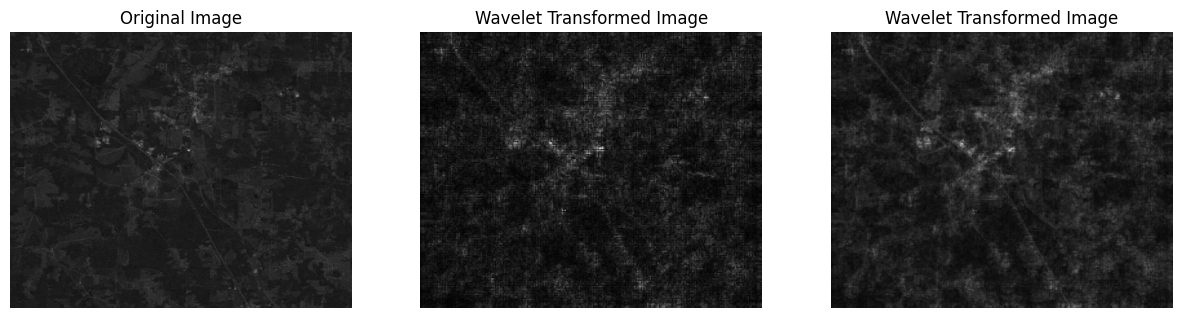

In [160]:
import numpy as np
import matplotlib.pyplot as plt

# Create a figure
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Display the original image
axs[0].imshow(image[1], cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')  # Hide axis labels

# Display the wavelet transformed image
axs[1].imshow(transformed_image[1], cmap='gray')
axs[1].set_title('Wavelet Transformed Image')
axs[1].axis('off')  # Hide axis labels

# Display the wavelet transformed image
axs[2].imshow(blended_image[1], cmap='gray')
axs[2].set_title('Wavelet Transformed Image')
axs[2].axis('off')  # Hide axis labels

plt.show()




In [139]:
import rasterio

# Open the original image to use its metadata for the new image
with rasterio.open('multidate_image.tif') as src:
    meta = src.meta.copy()  # Copy the metadata

# Update the metadata to reflect the number of bands and data type
# Note: Ensure the data type matches the dtype of your transformed_image
meta.update({
    'dtype': 'float32',  # Set dtype to float32 or another appropriate based on the transformed data
    'count': blended_image.shape[0]  # Set number of bands
})

# Save the transformed image to a new TIFF file
with rasterio.open('wavelet_transformed_image.tif', 'w', **meta) as dst:
    for i in range(blended_image.shape[0]):
        dst.write(blended_image[i, :, :], i + 1)  # Write each band


In [140]:
import geopandas as gpd
import rasterio
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Load the shapefile
gdf = gpd.read_file('Atlanta_training_data.shp')

# Convert polygons to centroids if not already points
if gdf.geometry.iloc[0].geom_type != 'Point':
    gdf['geometry'] = gdf.centroid

print(gdf.head())  # Check the centroid coordinates
def extract_values(gdf, raster_path):
    with rasterio.open(raster_path) as src:
        # List to store feature values
        feature_values = []
        # Iterate through each geometry in the dataframe
        for idx, row in gdf.iterrows():
            # Sample raster at the point location
            for val in src.sample([(row.geometry.x, row.geometry.y)]):
                feature_values.append(val)
        return np.array(feature_values)


# Prepare labels
labels = gdf['class'].values  # Replace 'label_column' with the actual name of the label column

# Load and prepare features from both the normal and wavelet-transformed images
features_normal = extract_values(gdf, 'multidate_image.tif')
features_wavelet = extract_values(gdf, 'wavelet_transformed_image.tif')

# Train and evaluate separate models
rf_normal = RandomForestClassifier(n_estimators=300, random_state=42)
rf_normal.fit(features_normal, labels)

rf_wavelet = RandomForestClassifier(n_estimators=300, random_state=42)
rf_wavelet.fit(features_wavelet, labels)




     id  class                    geometry
0  None      4  POINT (-84.15482 33.35704)
1  None      4  POINT (-84.12554 33.36443)
2  None      4  POINT (-84.16236 33.38014)
3  None      4  POINT (-84.17278 33.38443)
4  None      4  POINT (-84.15851 33.37226)


RandomForestClassifier(n_estimators=300, random_state=42)

In [141]:
import rasterio
from sklearn.ensemble import RandomForestClassifier

# Function to read, predict, and save classification for given image path and output path
def classify_and_save(image_path, output_path, model):
    # Read the entire image
    with rasterio.open(image_path) as src:
        # Read all bands and prepare the feature array
        all_bands = src.read()
        num_bands, height, width = all_bands.shape
        all_bands_reshaped = all_bands.reshape(num_bands, height * width).T
        meta = src.meta.copy()  # Copy metadata for saving later

    # Predict the classification for each pixel
    predicted_classes = model.predict(all_bands_reshaped)

    # Reshape the predicted classes back to the original image dimensions
    classified_image = predicted_classes.reshape((height, width))

    # Update metadata for saving the classified image
    meta.update({
        'dtype': 'int32',  # Ensure data type matches the type of `predicted_classes`
        'count': 1  # One band for classified results
    })

    # Save the classified image
    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(classified_image, 1)

# Assume 'rf_wavelet' and 'rf_normal' are your trained models for wavelet-transformed and normal images, respectively
wavelet_image_path = 'wavelet_transformed_image.tif'
normal_image_path = 'multidate_image.tif'

# Classify and save the results for the wavelet-transformed image
classify_and_save(normal_image_path, 'classified_wavelet_image.tif', rf_wavelet)

# Classify and save the results for the original image
classify_and_save(normal_image_path, 'classified_normal_image.tif', rf_normal)





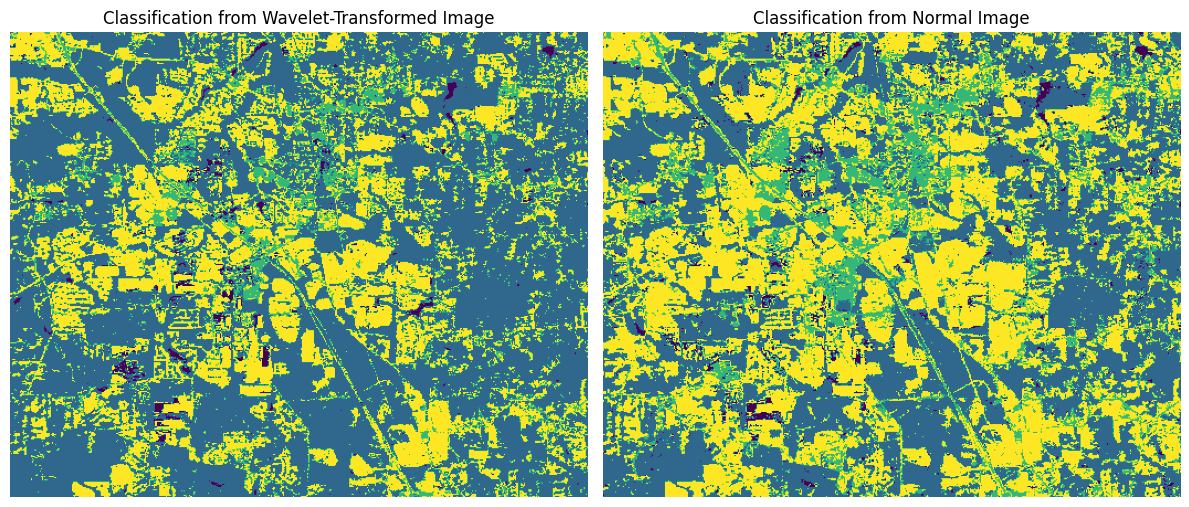

In [142]:
import rasterio
import matplotlib.pyplot as plt

# Function to load a classified image
def load_classified_image(path):
    with rasterio.open(path) as src:
        return src.read(1)  # Read the first band which contains the classification

# Paths to the classified images
classified_wavelet_image_path = 'classified_wavelet_image.tif'
classified_normal_image_path = 'classified_normal_image.tif'

# Load the images
classified_wavelet_image = load_classified_image(classified_wavelet_image_path)
classified_normal_image = load_classified_image(classified_normal_image_path)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Adjust size as needed

# Plot wavelet-transformed classification
axes[0].imshow(classified_wavelet_image, cmap='viridis')  # You can change the colormap as needed
axes[0].set_title('Classification from Wavelet-Transformed Image')
axes[0].axis('off')  # Hide axes

# Plot normal image classification
axes[1].imshow(classified_normal_image, cmap='viridis')
axes[1].set_title('Classification from Normal Image')
axes[1].axis('off')  # Hide axes

# Display the plots
plt.tight_layout()
plt.show()




In [3]:
import rasterio
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import random

def generate_stratified_samples(raster_path, num_samples, class_values, class_points, scale):
    with rasterio.open(raster_path) as src:
        band = src.read(1)  # Read the first band (classification result)

        # Prepare to store sample points
        points = []

        # Process each class
        for class_value, points_count in zip(class_values, class_points):
            # Find all pixel indices of the current class
            indices = np.column_stack(np.where(band == class_value))
            
            # Check if we have enough pixels to sample from
            if len(indices) < points_count:
                raise ValueError(f"Not enough pixels for class {class_value}. Reduce sample count.")
            
            # Randomly select 'points_count' indices
            sampled_indices = indices[random.sample(range(len(indices)), points_count)]
            
            # Convert pixel coordinates to geographical coordinates and create points
            for (row, col) in sampled_indices:
                x, y = src.xy(row, col)  # Get coordinates for the given row and col
                points.append(Point(x, y))

        # Create a GeoDataFrame to hold the geometry and class values
        gdf = gpd.GeoDataFrame({
            'geometry': points,
            'class': [val for val, count in zip(class_values, class_points) for _ in range(count)]
        }, crs=src.crs)

    return gdf

# Path to your classified raster
raster_path = 'classified_wavelet_image.tif'

# Parameters for sampling
num_points = 200  # Total number of points to sample
class_values = [0, 1, 2, 3, 4]  # Class labels
class_points = [0,10,50,40,55]  # Number of points per class
scale = 30  # Scale in meters, if applicable

# Generate samples
sample_points = generate_stratified_samples(raster_path, num_points, class_values, class_points, scale)

# Save the sample points to a shapefile
output_path = 'sample_points.shp'  # Define the output file path
sample_points.to_file(output_path, driver='ESRI Shapefile')

print(f"Sample points saved to {output_path}")


Sample points saved to sample_points.shp


In [5]:
import geopandas as gpd
import rasterio
import numpy as np
from sklearn.metrics import confusion_matrix


def calculate_confusion_matrix(classified_image_path, test_samples_path, reference_column):
    # Load the shapefile containing test samples
    test_samples = gpd.read_file(test_samples_path)

    # Open the classified image to sample from it
    with rasterio.open(classified_image_path) as src:
        # Ensure the CRS matches between the test samples and the raster
        if test_samples.crs != src.crs:
            test_samples = test_samples.to_crs(src.crs)

        # Extract raster values at points
        values = [list(src.sample([(geom.x, geom.y)]))[0][0] for geom in test_samples.geometry]

    # Assuming the shapefile has a column with the true labels
    true_labels = test_samples[reference_column].values

    # Generate the confusion matrix
    cm = confusion_matrix(true_labels, values)

    return cm

# Paths to the classified images
classified_wavelet_image_path = 'classified_wavelet_image.tif'
classified_normal_image_path = 'classified_normal_image.tif'

# Path to the shapefile and the column name with the true labels
test_samples_path = 'sample_points.shp'
reference_column = 'reference'

# Calculate confusion matrices
cm_wavelet = calculate_confusion_matrix(classified_wavelet_image_path, test_samples_path, reference_column)
cm_normal = calculate_confusion_matrix(classified_normal_image_path, test_samples_path, reference_column)

# Print the confusion matrices
print("Confusion Matrix for Wavelet-Transformed Image Classification:")
print(cm_wavelet)
print("Confusion Matrix for Normal Image Classification:")
print(cm_normal)





Confusion Matrix for Wavelet-Transformed Image Classification:
[[ 5  0  0  0]
 [ 0 50  6 10]
 [ 2  0 34  1]
 [ 3  0  0 44]]
Confusion Matrix for Normal Image Classification:
[[ 3  0  0  2]
 [ 1 35 10 20]
 [ 0  0 32  5]
 [ 1  0  5 41]]


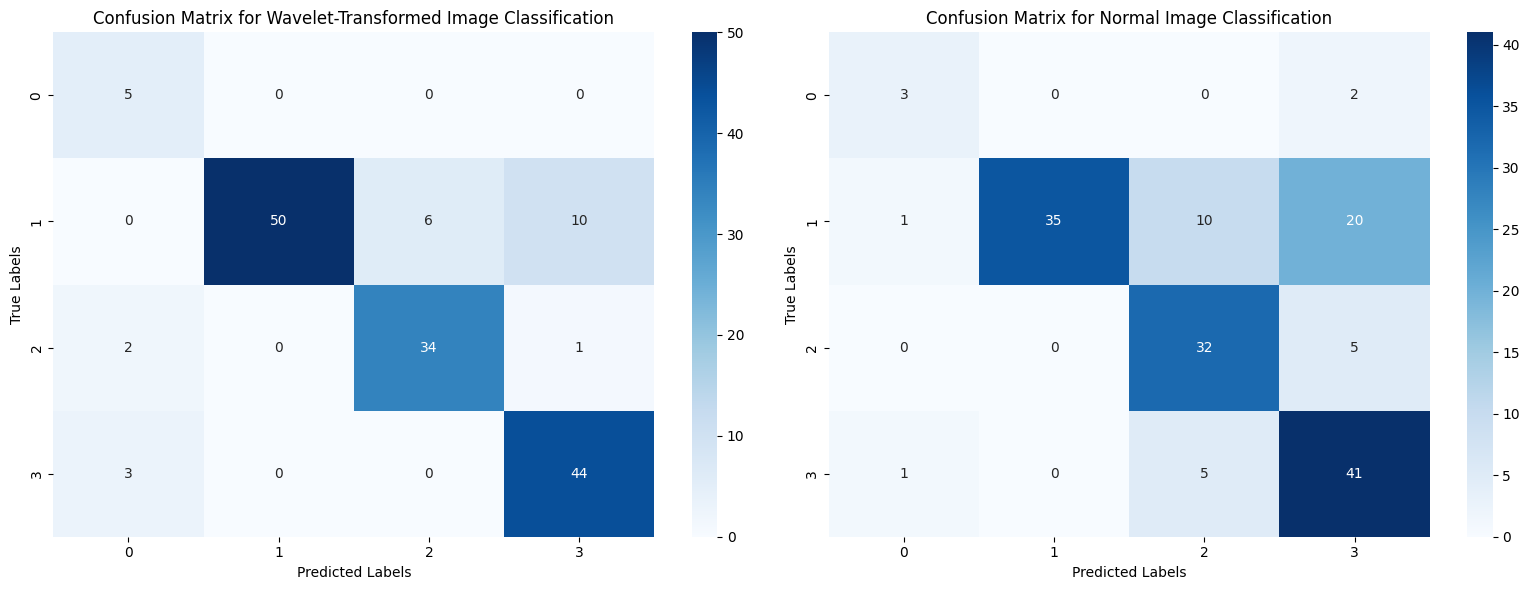

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrices(cm1, cm2, title1='Confusion Matrix 1', title2='Confusion Matrix 2'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # Adjust overall figure size as needed

    # Plotting the first confusion matrix
    sns.heatmap(cm1, annot=True, fmt="d", cmap='Blues', xticklabels=True, yticklabels=True, ax=ax1)
    ax1.set_title(title1)
    ax1.set_xlabel('Predicted Labels')
    ax1.set_ylabel('True Labels')

    # Plotting the second confusion matrix
    sns.heatmap(cm2, annot=True, fmt="d", cmap='Blues', xticklabels=True, yticklabels=True, ax=ax2)
    ax2.set_title(title2)
    ax2.set_xlabel('Predicted Labels')
    ax2.set_ylabel('True Labels')

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()


plot_confusion_matrices(cm_wavelet, cm_normal, 
                        title1='Confusion Matrix for Wavelet-Transformed Image Classification',
                        title2='Confusion Matrix for Normal Image Classification')




In [144]:
import rasterio
from rasterio.plot import show
from ipyleaflet import Map, ImageOverlay, basemaps
from ipywidgets import widgets, VBox, interactive
import matplotlib.pyplot as plt
from io import BytesIO
import base64

def fig_to_overlay(fig):
    io = BytesIO()
    fig.savefig(io, format='png', bbox_inches='tight', pad_inches=0, transparent=True)
    io.seek(0)
    image_base64 = base64.b64encode(io.getvalue()).decode('utf-8')
    return f"data:image/png;base64,{image_base64}"

def get_bounds(src):
    t = src.transform
    return [(t.f, t.c), (t.f + t.e * src.height, t.c + t.a * src.width)]

def create_map_with_controls(image_paths):
    # Load the images and create overlays
    overlays = []
    bounds = None

    for path in image_paths:
        with rasterio.open(path) as src:
            data = src.read(1)
            bounds = get_bounds(src)
            fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
            show(data, ax=ax, transform=src.transform, cmap='viridis')
            ax.axis('off')
            overlay_url = fig_to_overlay(fig)
            plt.close(fig)
            overlay = ImageOverlay(url=overlay_url, bounds=bounds, visible=False)
            overlays.append(overlay)

    # Create the map with satellite view
    m = Map(center=[(bounds[0][0] + bounds[1][0]) / 2, (bounds[0][1] + bounds[1][1]) / 2],
            zoom=10, basemap=basemaps.Esri.WorldImagery)

    for overlay in overlays:
        m.add_layer(overlay)

    # Slider for selecting images
    image_slider = widgets.IntSlider(description='Image Index', min=0, max=len(overlays) - 1, value=0)
    opacity_slider = widgets.FloatSlider(description='Opacity', min=0, max=1, value=1, step=0.1)

    def on_image_slider_change(change):
        for index, overlay in enumerate(overlays):
            overlay.visible = (index == change['new'])

    def on_opacity_slider_change(change):
        for overlay in overlays:
            overlay.opacity = change['new']

    image_slider.observe(on_image_slider_change, names='value')
    opacity_slider.observe(on_opacity_slider_change, names='value')

    overlays[0].visible = True

    return VBox([m, image_slider, opacity_slider])

image_paths = ['classified_wavelet_image.tif', 'classified_normal_image.tif']
map_with_controls = create_map_with_controls(image_paths)
map_with_controls


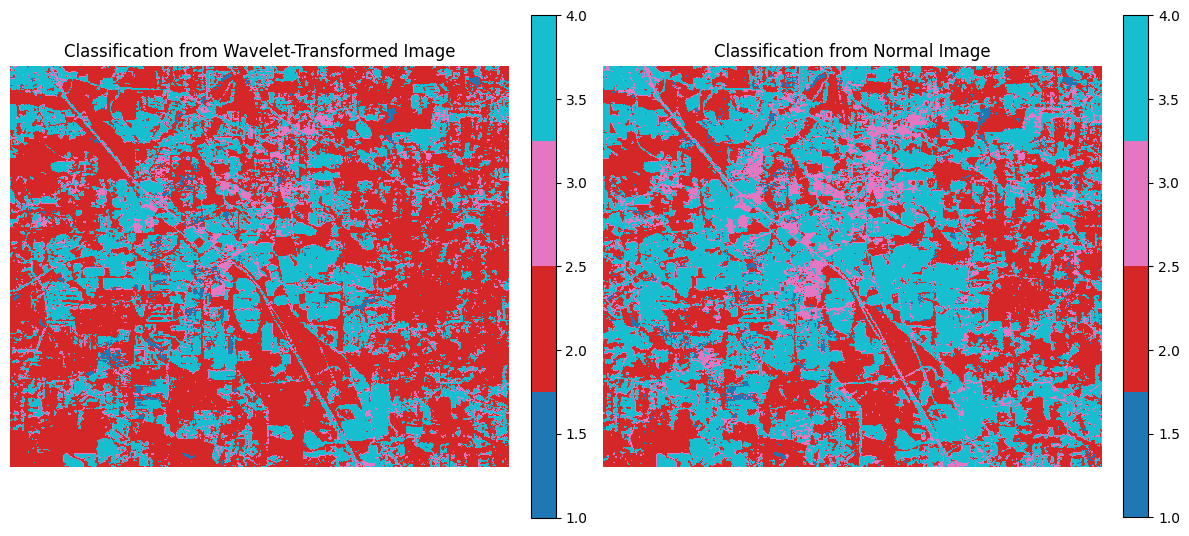

In [145]:
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Function to load a classified image
def load_classified_image(path):
    with rasterio.open(path) as src:
        return src.read(1)  # Read the first band which contains the classification

# Paths to the classified images
classified_wavelet_image_path = 'classified_wavelet_image.tif'
classified_normal_image_path = 'classified_normal_image.tif'

# Load the images
classified_wavelet_image = load_classified_image(classified_wavelet_image_path)
classified_normal_image = load_classified_image(classified_normal_image_path)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Use tab10 colormap
cmap = plt.get_cmap('tab10', 4)  # Get 4 distinct colors from tab10

# Define the color normalization based on the classification values (0 to 3)
norm = Normalize(vmin=1, vmax=4)

# Plot wavelet-transformed classification
im = axes[0].imshow(classified_wavelet_image, cmap=cmap, norm=norm)
axes[0].set_title('Classification from Wavelet-Transformed Image')
axes[0].axis('off')
fig.colorbar(im, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)

# Plot normal image classification
im2 = axes[1].imshow(classified_normal_image, cmap=cmap, norm=norm)
axes[1].set_title('Classification from Normal Image')
axes[1].axis('off')
fig.colorbar(im2, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)

# Display the plots
plt.tight_layout()
plt.show()



In [146]:
import rasterio
from rasterio.plot import show
from ipyleaflet import Map, ImageOverlay, basemaps
from ipywidgets import widgets, VBox, interactive
import matplotlib.pyplot as plt
from io import BytesIO
import base64

def fig_to_overlay(fig):
    io = BytesIO()
    fig.savefig(io, format='png', bbox_inches='tight', pad_inches=0, transparent=True)
    io.seek(0)
    image_base64 = base64.b64encode(io.getvalue()).decode('utf-8')
    return f"data:image/png;base64,{image_base64}"

def get_bounds(src):
    t = src.transform
    return [(t.f, t.c), (t.f + t.e * src.height, t.c + t.a * src.width)]

def create_map_with_controls(image_paths):
    # Load the images and create overlays
    overlays = []
    bounds = None

    for path in image_paths:
        with rasterio.open(path) as src:
            data = src.read(1)
            bounds = get_bounds(src)
            fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
            cmap = plt.get_cmap('tab10', 4)  # Customize number of colors as needed, 4 for four categories
            show(data, ax=ax, transform=src.transform, cmap=cmap)
            ax.axis('off')
            overlay_url = fig_to_overlay(fig)
            plt.close(fig)
            overlay = ImageOverlay(url=overlay_url, bounds=bounds, visible=False)
            overlays.append(overlay)

    # Create the map with satellite view
    m = Map(center=[(bounds[0][0] + bounds[1][0]) / 2, (bounds[0][1] + bounds[1][1]) / 2],
            zoom=10, basemap=basemaps.Esri.WorldImagery)

    for overlay in overlays:
        m.add_layer(overlay)

    # Slider for selecting images and controlling opacity
    image_slider = widgets.IntSlider(description='Image Index', min=0, max=len(overlays) - 1, value=0)
    opacity_slider = widgets.FloatSlider(description='Opacity', min=0, max=1, value=1, step=0.1)

    def on_image_slider_change(change):
        for index, overlay in enumerate(overlays):
            overlay.visible = (index == change['new'])

    def on_opacity_slider_change(change):
        for overlay in overlays:
            overlay.opacity = change['new']

    image_slider.observe(on_image_slider_change, names='value')
    opacity_slider.observe(on_opacity_slider_change, names='value')

    overlays[0].visible = True  # Make the first image visible initially

    return VBox([m, image_slider, opacity_slider])

image_paths = ['classified_wavelet_image.tif', 'classified_normal_image.tif']
map_with_controls = create_map_with_controls(image_paths)
map_with_controls
